# Audio Analysis for Movie Clips

This notebook analyzes the audio track of a movie clip to extract key audio features over time.
We'll extract tempo (BPM), energy levels, silence detection, and optionally emotion from the audio.
These features can complement visual analysis to provide a more complete understanding of a movie's emotional journey.

## Setup

First, let's import the required libraries:

In [1]:
# Install any missing packages
!pip install librosa matplotlib pandas numpy scipy tqdm soundfile

# Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)


## Load Audio File

We'll load the audio file that was extracted earlier:

In [2]:
# Define the audio file path
audio_file = 'outputs/sample_audio.wav'
# Set this manually or pass from UI in future
video_type = "trailer"  # options: vlog, podcast, dance, scene, etc.
# Save video type for downstream usage
with open("outputs/video_type.txt", "w") as f:
    f.write(video_type)
# Load the audio file using librosa
try:
    # Load audio with original sampling rate
    y, sr = librosa.load(audio_file, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    
    print(f"Audio loaded successfully!")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Shape: {y.shape}")
except Exception as e:
    print(f"Error loading audio file: {str(e)}")


Audio loaded successfully!
Duration: 137.51 seconds
Sample rate: 44100 Hz
Shape: (6064191,)


## Visualize Audio Waveform

Let's first visualize the waveform of the entire audio track:

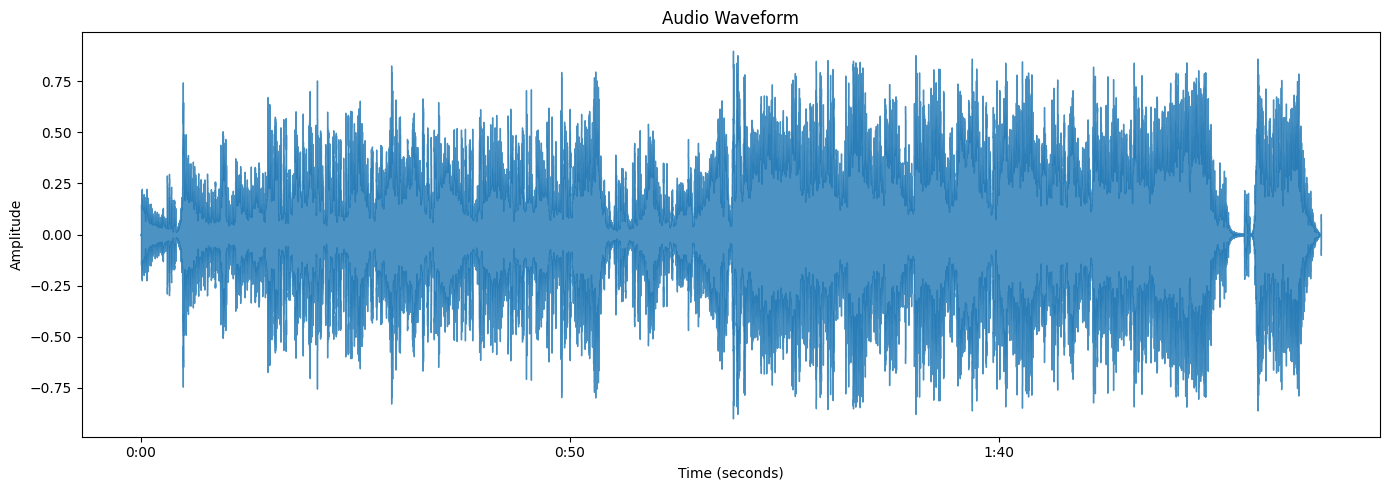

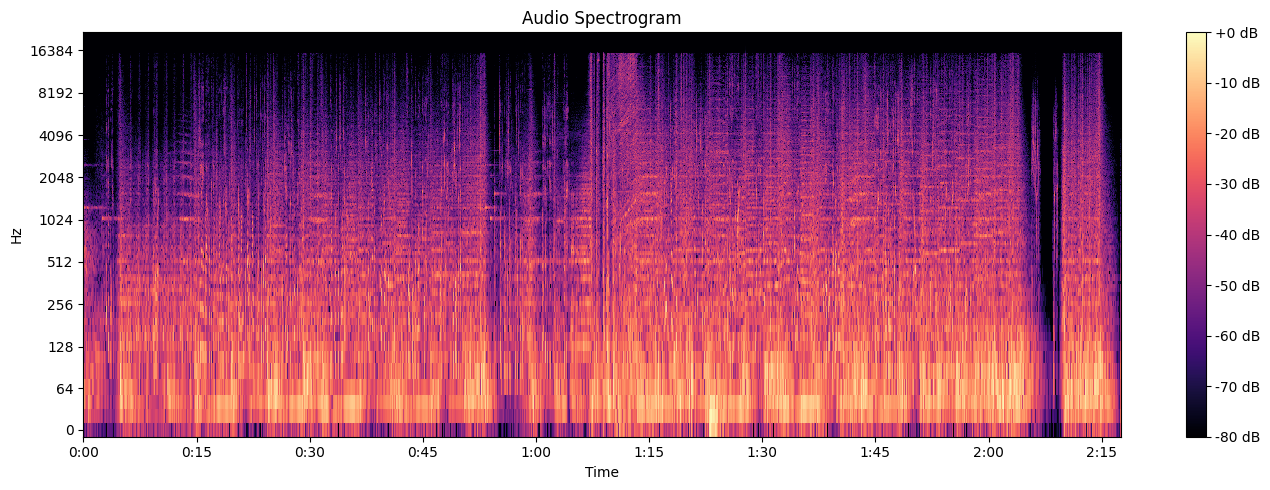

In [3]:
# Plot the waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y, sr=sr, alpha=0.8)
plt.title('Audio Waveform')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.tight_layout()
plt.show()

# Plot the spectrogram
plt.figure(figsize=(14, 5))
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Audio Spectrogram')
plt.tight_layout()
plt.show()


## Split Audio into Chunks

Now we'll split the audio into short chunks (e.g., 2-second segments) for analysis:

In [4]:
# Define the chunk size in seconds
chunk_size = 2.0  # 2-second chunks

# Calculate the number of samples per chunk
chunk_samples = int(chunk_size * sr)

# Calculate the number of chunks
num_chunks = int(np.ceil(len(y) / chunk_samples))

print(f"Splitting audio into {num_chunks} chunks of {chunk_size} seconds each")

# Create chunks
chunks = []
for i in range(num_chunks):
    start_sample = i * chunk_samples
    end_sample = min((i + 1) * chunk_samples, len(y))
    
    chunk = y[start_sample:end_sample]
    
    # If last chunk is too short, pad with zeros
    if len(chunk) < chunk_samples:
        chunk = np.pad(chunk, (0, chunk_samples - len(chunk)))
    
    chunks.append(chunk)

print(f"Created {len(chunks)} chunks")


Splitting audio into 69 chunks of 2.0 seconds each
Created 69 chunks


## Extract Audio Features

For each audio chunk, we'll extract the following features:
1. Tempo (BPM)
2. Energy (RMS)
3. Silence detection
4. (Optional) Audio emotion

In [5]:
# Function to extract audio features from a chunk
def extract_features(chunk, sr):
    features = {}
    
    # Estimate tempo (BPM)
    # Note: This is approximate and works better on longer audio segments
    try:
        onset_env = librosa.onset.onset_strength(y=chunk, sr=sr)
        tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)[0]
        features['tempo'] = tempo
    except:
        features['tempo'] = np.nan
    
    # Compute energy (RMS)
    energy = np.sqrt(np.mean(chunk**2))
    features['energy'] = energy
    
    # Detect if it's mostly silent
    # Define a threshold for silence (adjust as needed)
    silence_threshold = 0.01  # You may need to tune this
    is_silent = energy < silence_threshold
    features['is_silent'] = is_silent
    
    return features

# Extract features from each chunk
print("Extracting audio features...")
chunk_features = []

for i, chunk in enumerate(tqdm(chunks)):
    # Calculate time boundaries
    start_time = i * chunk_size
    end_time = start_time + chunk_size
    
    # Extract features
    features = extract_features(chunk, sr)
    
    # Add time information
    features['timestamp_start'] = start_time
    features['timestamp_end'] = end_time
    
    chunk_features.append(features)

# Create DataFrame
features_df = pd.DataFrame(chunk_features)
print(f"Extracted features for {len(features_df)} chunks")
features_df.head()


Extracting audio features...


  0%|          | 0/69 [00:00<?, ?it/s]

Extracted features for 69 chunks


,tempo,energy,is_silent,timestamp_start,timestamp_end
0,143.554688,0.054078,False,0.0,2.0
1,161.499023,0.046256,False,2.0,4.0
2,132.512019,0.123161,False,4.0,6.0
3,132.512019,0.075874,False,6.0,8.0
4,132.512019,0.090931,False,8.0,10.0


## Audio Emotion Classification (Simulated)

Since actual audio emotion classification requires specialized models, we'll simulate this feature.
In a real-world application, you would use a pre-trained speech emotion recognition model.

In [6]:
# Simulate emotion classification
# In production, you would use a real model like pyAudioAnalysis, speechemotionrecognition, etc.

import random

# Available emotion categories
emotions = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'excited', 'surprised']

# Function to simulate emotion detection 
def mock_emotion_detection(energy, is_silent):
    if is_silent:
        # If silent, most likely neutral
        return 'neutral', random.uniform(0.7, 0.9)
    elif energy > 0.05:
        # High energy might indicate excited, happy, or angry
        emotion = random.choice(['excited', 'happy', 'angry'])
        return emotion, random.uniform(0.6, 0.85)
    else:
        # Lower energy might indicate calm, sad, or neutral
        emotion = random.choice(['calm', 'sad', 'neutral'])
        return emotion, random.uniform(0.55, 0.8)

# Apply mock emotion detection
emotions_data = []
for _, row in features_df.iterrows():
    emotion, confidence = mock_emotion_detection(row['energy'], row['is_silent'])
    emotions_data.append({
        'timestamp_start': row['timestamp_start'],
        'timestamp_end': row['timestamp_end'],
        'emotion': emotion,
        'confidence': confidence
    })

# Create emotion DataFrame
emotion_df = pd.DataFrame(emotions_data)

# Show the emotions
emotion_df.head()

# Add emotion to features dataframe
features_df['emotion'] = emotion_df['emotion']
features_df['emotion_confidence'] = emotion_df['confidence']


## Save Results

Let's save the audio analysis results to a CSV file:

In [7]:
# Save to CSV
output_file = 'outputs/audio_analysis.csv'
features_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


Results saved to outputs/audio_analysis.csv


## Visualize Audio Analysis

Now let's create some visualizations to better understand the audio patterns:

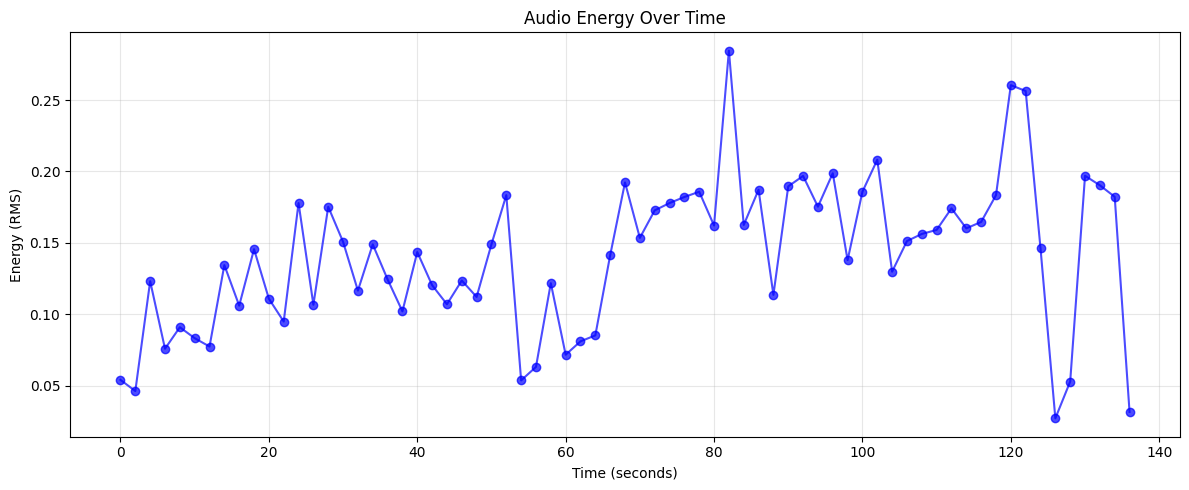

In [8]:
# Plot Energy vs. Time
plt.figure(figsize=(12, 5))
plt.plot(features_df['timestamp_start'], features_df['energy'], marker='o', linestyle='-', color='blue', alpha=0.7)
plt.title('Audio Energy Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Energy (RMS)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


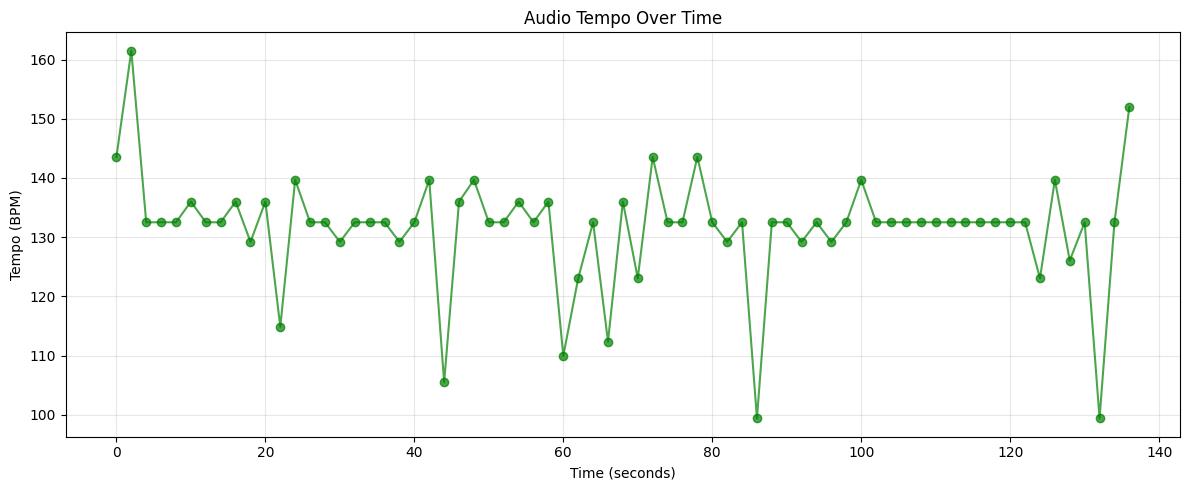

In [9]:
# Plot Tempo vs. Time
plt.figure(figsize=(12, 5))
plt.plot(features_df['timestamp_start'], features_df['tempo'], marker='o', linestyle='-', color='green', alpha=0.7)
plt.title('Audio Tempo Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Tempo (BPM)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


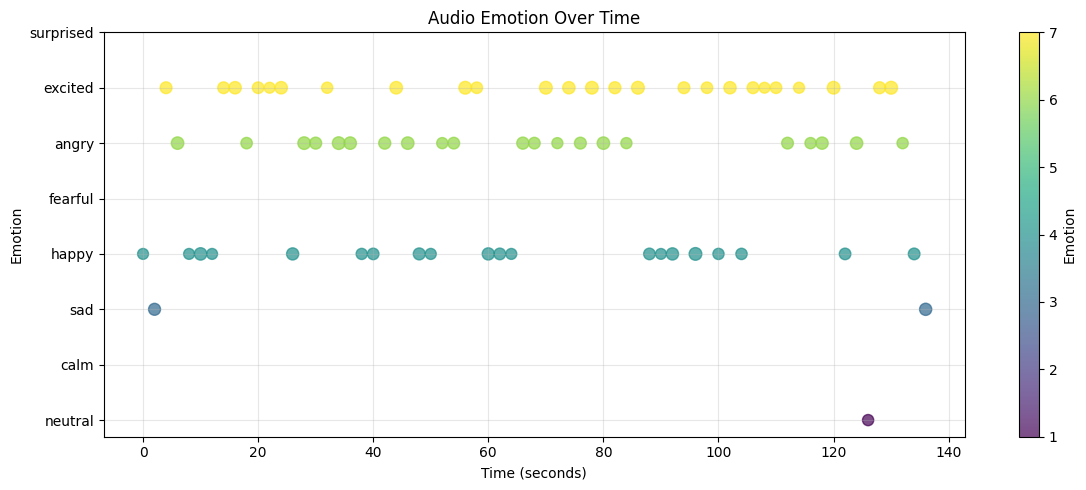

In [10]:
# Create a mapping of emotions to numeric values for plotting
emotion_map = {
    'neutral': 1,
    'calm': 2,
    'sad': 3,
    'happy': 4,
    'fearful': 5,
    'angry': 6,
    'excited': 7,
    'surprised': 8
}

# Add numeric emotion value
features_df['emotion_value'] = features_df['emotion'].map(lambda x: emotion_map.get(x, 0))

# Plot Emotion vs. Time
plt.figure(figsize=(12, 5))
plt.scatter(
    features_df['timestamp_start'], 
    features_df['emotion_value'],
    c=features_df['emotion_value'], 
    s=features_df['emotion_confidence'] * 100,  # Size based on confidence
    cmap='viridis',
    alpha=0.7
)
plt.title('Audio Emotion Over Time')
plt.xlabel('Time (seconds)')
plt.ylabel('Emotion')
plt.yticks(list(emotion_map.values()), list(emotion_map.keys()))
plt.grid(True, alpha=0.3)
plt.colorbar(ticks=list(emotion_map.values()), label='Emotion')
plt.tight_layout()
plt.show()


## Combined Audio Features Visualization

Let's create a combined visualization to see how energy, tempo, and emotions relate to each other:

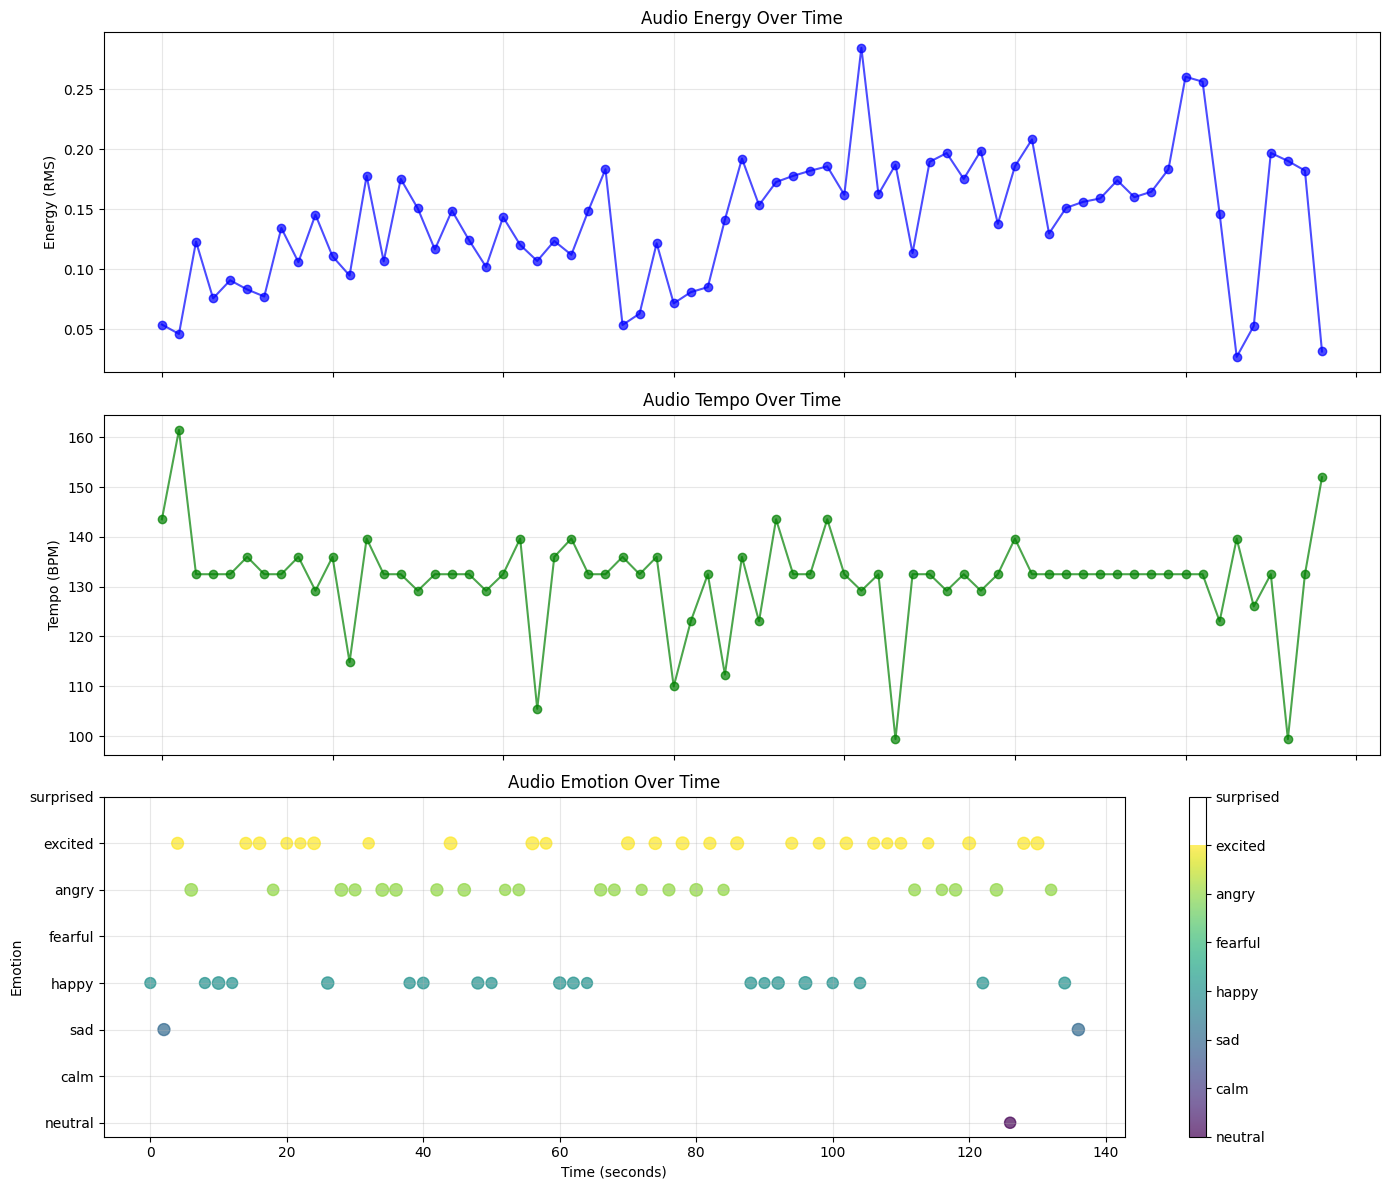

In [11]:
# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Energy
ax1.plot(features_df['timestamp_start'], features_df['energy'], 'b-', marker='o', alpha=0.7)
ax1.set_ylabel('Energy (RMS)')
ax1.set_title('Audio Energy Over Time')
ax1.grid(True, alpha=0.3)

# Plot Tempo
ax2.plot(features_df['timestamp_start'], features_df['tempo'], 'g-', marker='o', alpha=0.7)
ax2.set_ylabel('Tempo (BPM)')
ax2.set_title('Audio Tempo Over Time')
ax2.grid(True, alpha=0.3)

# Plot Emotions
scatter = ax3.scatter(
    features_df['timestamp_start'], 
    features_df['emotion_value'],
    c=features_df['emotion_value'], 
    s=features_df['emotion_confidence'] * 100,
    cmap='viridis',
    alpha=0.7
)
ax3.set_ylabel('Emotion')
ax3.set_title('Audio Emotion Over Time')
ax3.set_yticks(list(emotion_map.values()))
ax3.set_yticklabels(list(emotion_map.keys()))
ax3.grid(True, alpha=0.3)

# Add colorbar
cbar = fig.colorbar(scatter, ax=ax3)
cbar.set_ticks(list(emotion_map.values()))
cbar.set_ticklabels(list(emotion_map.keys()))

# Set common x-axis label
plt.xlabel('Time (seconds)')

# Adjust layout
plt.tight_layout()
plt.show()


## Silence Detection

Let's visualize where silence was detected in the audio:

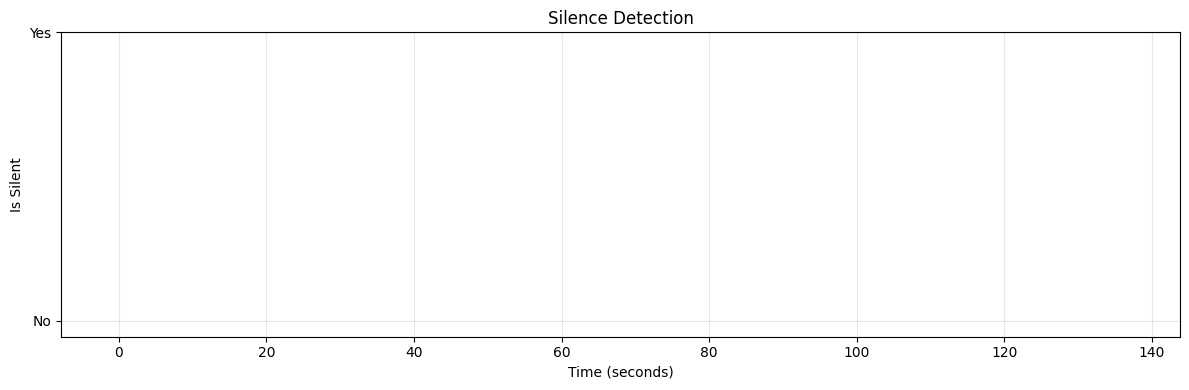

In [12]:
# Plot silence detection
plt.figure(figsize=(12, 4))
plt.bar(
    features_df['timestamp_start'], 
    features_df['is_silent'].astype(int), 
    width=chunk_size*0.9,
    color='red',
    alpha=0.5
)
plt.title('Silence Detection')
plt.xlabel('Time (seconds)')
plt.ylabel('Is Silent')
plt.yticks([0, 1], ['No', 'Yes'])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Summary and Insights

This audio analysis provides valuable insights into the audio layer of the movie clip:

- **Energy patterns**: Shows the intensity of sound throughout the clip, which can indicate action sequences or emotional moments.
- **Tempo changes**: Reveals the pacing of the soundtrack, which often correlates with the narrative tempo.
- **Silence detection**: Identifies quiet moments that may serve as dramatic pauses or transitions.
- **Emotion prediction**: Offers insight into the emotional tone conveyed through audio.

### Next Steps

- Combine audio analysis with visual emotion detection for multimodal analysis
- Detect speech vs. music vs. sound effects
- Use more advanced audio feature extraction like spectral centroid, chroma, or MFCCs
- Implement a proper audio emotion recognition model
